#**Text Classification using BERT**

Fine-tuning BERT for a classification task on the NTC-SCV dataset using the Transformers library from HuggingFace.

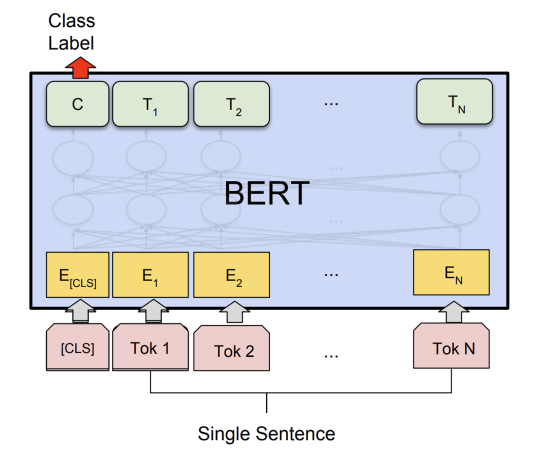

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

###**Load Dataset**

In [ ]:
#!pip install -q -U transformers datasets accelerate evaluate

In [ ]:
# download dataset
#!git clone https://github.com/congnghia0609/ntc-scv.git

In [ ]:
#!unzip /content/ntc-scv/data/data_train.zip -d /content/drive/MyDrive/RAW/IMPLEMENT/deep_learning/transformer/NTC-SCV
#!unzip /content/ntc-scv/data/data_test.zip -d /content/drive/MyDrive/RAW/IMPLEMENT/deep_learning/transformer/NTC-SCV

In [ ]:
import os
import pandas as pd

def load_data_from_path(folder_path):
  examples = []
  for label in os.listdir(folder_path):
    full_path = os.path.join(folder_path, label)
    for file_name in os.listdir(full_path):
      file_path = os.path.join(full_path, file_name)
      with open(file_path, "r", encoding="utf-8") as f:
          lines = f.readlines()
      sentence = " ".join(lines)
      if label == "neg":
          label = 0
      if label == "pos":
          label = 1
      data = {
          'sentence': sentence,
          'label': label
      }
      examples.append(data)
  return pd.DataFrame(examples)

folder_paths = {
  'train': '/content/drive/MyDrive/RAW/IMPLEMENT/deep_learning/transformer/NTC-SCV/data_train/train',
  'valid': '/content/drive/MyDrive/RAW/IMPLEMENT/deep_learning/transformer/NTC-SCV/data_train/test',
  'test': '/content/drive/MyDrive/RAW/IMPLEMENT/deep_learning/transformer/NTC-SCV/data_test/test'
}

train_df = load_data_from_path(folder_paths['train'])
valid_df = load_data_from_path(folder_paths['valid'])
test_df = load_data_from_path(folder_paths['test'])

In [ ]:
train_df.head()

,sentence,label
0,Gà nướng phô_mai siêu ngon lại giá_cả phải_chă...,1
1,CLB Bia . Điểm giải_trí dành cho giới trẻ . Rấ...,1
2,Lâu_đài này theo mình biết là cafe lúc đầu chỉ...,1
3,"Mình thích 1 là ăn_ở đây , nv thân_thiện , quá...",1
4,Lần trước về có mua bên chỗ này lần này về ord...,1


In [ ]:
train_df.to_csv('/content/drive/MyDrive/RAW/IMPLEMENT/deep_learning/transformer/NTC-SCV/train', sep='\t', encoding='utf-8', index=False, header=True)
valid_df.to_csv('/content/drive/MyDrive/RAW/IMPLEMENT/deep_learning/transformer/NTC-SCV/val', sep='\t', encoding='utf-8', index=False, header=True)
test_df.to_csv('/content/drive/MyDrive/RAW/IMPLEMENT/deep_learning/transformer/NTC-SCV/test', sep='\t', encoding='utf-8', index=False, header=True)


###**Preprocessing**

####**Text Cleaning**

In [ ]:
import re
import string

def preprocess_text(text):
    # remove URLs https://www.
    url_pattern = re.compile(r'https?://\s+\wwww\.\s+')
    text = url_pattern.sub(r" ", text)

    # remove HTML Tags: <>
    html_pattern = re.compile(r'<[^<>]+>')
    text = html_pattern.sub(" ", text)

    # remove puncs and digits
    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, " ")

    # remove emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r" ", text)

    # normalize whitespace
    text = " ".join(text.split())

    # lowercasing
    text = text.lower()
    return text

In [ ]:
train_df['sentence'] = [preprocess_text(row['sentence']) for index, row in train_df.iterrows()]
valid_df['sentence'] = [preprocess_text(row['sentence']) for index, row in valid_df.iterrows()]
test_df['sentence'] = [preprocess_text(row['sentence']) for index, row in test_df.iterrows()]

####**Convert to Dataset Object**

In [ ]:
from datasets import Dataset, DatasetDict

raw_dataset = DatasetDict({
    'train': Dataset.from_pandas(train_df),
    'valid': Dataset.from_pandas(valid_df),
    'test': Dataset.from_pandas(test_df)
})

In [ ]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 30000
    })
    valid: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10000
    })
})

####**Tokenizer**

In [ ]:
from transformers import AutoTokenizer

model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    use_fast=True
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
max_seq_length = 100
max_seq_length = min(max_seq_length, tokenizer.model_max_length)

def preprocess_function(examples):
  # Tokenize the texts
  result = tokenizer(
    examples["sentence"],
    padding="max_length",
    max_length=max_seq_length,
    truncation=True
  )
  result["label"] = examples['label']

  return result

In [ ]:
# Running the preprocessing pipeline on all the datasets
processed_dataset = raw_dataset.map(
    preprocess_function,
    batched=True,
    desc="Running tokenizer on dataset",
)

Running tokenizer on dataset:   0%|          | 0/30000 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
processed_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 30000
    })
    valid: Dataset({
        features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10000
    })
})

In [ ]:
processed_dataset['train'][0]

{'sentence': 'gà nướng phô mai siêu ngon lại giá cả phải chăng suất đủ cho ng ăn bình thường ng nếu ăn khỏe ăn trưa mỗi ng hết có tầm k mà lè lưỡi vì no luôn mỗi cái đi ăn sớm trc h thì phải chờ hơi lâu',
 'label': 1,
 'input_ids': [101,
  11721,
  16371,
  5063,
  6887,
  2080,
  14736,
  9033,
  13765,
  17895,
  2078,
  21110,
  27699,
  6187,
  6887,
  4886,
  11132,
  10514,
  4017,
  1102,
  2226,
  16480,
  12835,
  2019,
  8026,
  2232,
  16215,
  19098,
  3070,
  12835,
  11265,
  2226,
  2019,
  1047,
  14490,
  2019,
  19817,
  6692,
  25175,
  12835,
  21770,
  2522,
  17214,
  1047,
  5003,
  3393,
  11320,
  10448,
  6819,
  2053,
  11320,
  2239,
  25175,
  29080,
  1102,
  2072,
  2019,
  2061,
  2213,
  19817,
  2278,
  1044,
  16215,
  2072,
  6887,
  4886,
  16480,
  7570,
  2072,
  21360,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'token_type_ids': [0,
  0,

####**Collator with padding max length**

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

###**Modeling**

In [ ]:
from transformers import AutoConfig, AutoModelForSequenceClassification

num_labels = 2

config = AutoConfig.from_pretrained(
    model_name,
    num_labels=num_labels,
    finetuning_task="text-classification"
)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    config=config
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

###**Metric**

In [ ]:
#!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    result = metric.compute(predictions=predictions, references=labels)
    return result

###**Trainer**

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/RAW/IMPLEMENT/deep_learning/transformer/bert/cls",
    learning_rate=2e-5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

/tmp/ipython-input-2972096816.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


###**Training**

In [ ]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hpl114p (hpl114p-haui) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.442969,0.800600
2,No log,0.394738,0.830700
3,0.450300,0.382611,0.835700
4,0.450300,0.369072,0.846900
5,0.319700,0.381173,0.845000
6,0.319700,0.424884,0.838200
7,0.246700,0.411137,0.847200
8,0.246700,0.456298,0.841100
9,0.188700,0.471835,0.841600
10,0.188700,0.480663,0.842200


TrainOutput(global_step=2350, training_loss=0.28044899311471494, metrics={'train_runtime': 5596.7324, 'train_samples_per_second': 53.603, 'train_steps_per_second': 0.42, 'total_flos': 1.54166634e+16, 'train_loss': 0.28044899311471494, 'epoch': 10.0})

###**Evaluation**

In [ ]:
trainer.evaluate(processed_dataset["test"])

{'eval_loss': 0.3465272784233093,
 'eval_accuracy': 0.855,
 'eval_runtime': 58.8655,
 'eval_samples_per_second': 169.879,
 'eval_steps_per_second': 1.342,
 'epoch': 10.0}

###**Visualization**

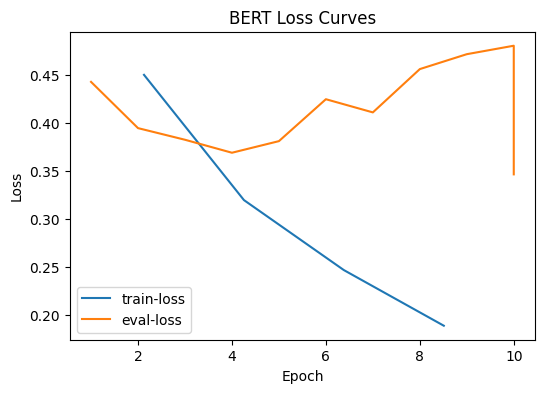

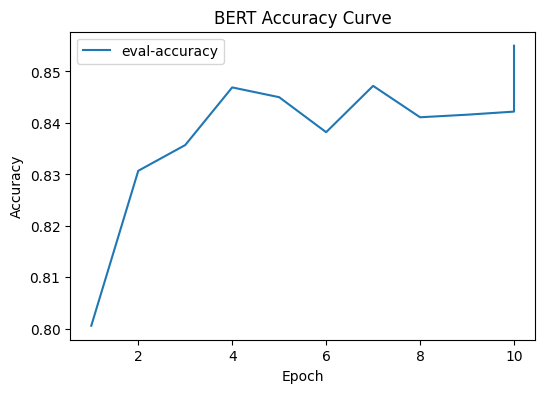

In [ ]:
import matplotlib.pyplot as plt
# Collect logs ---------------------------------------------------------------
logs = trainer.state.log_history
train_loss, eval_loss, eval_acc, steps_eval, steps_train = [], [], [], [], []

for e in logs:
    if 'loss' in e and e.get("epoch") is not None:
        train_loss.append(e['loss'])
        steps_train.append(e['epoch'])
    if 'eval_loss' in e:
        eval_loss.append(e['eval_loss'])
        eval_acc.append(e['eval_accuracy'])
        steps_eval.append(e['epoch'])

# Plot -----------------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(steps_train, train_loss, label="train-loss")
plt.plot(steps_eval, eval_loss, label="eval-loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("BERT Loss Curves")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(steps_eval, eval_acc, label="eval-accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("BERT Accuracy Curve")
plt.show()

###**Save model to huggingface**

In [ ]:
from huggingface_hub import HfApi

api = HfApi(token=os.getenv("HF_TOKEN"))
api.upload_folder(
    folder_path="/content/drive/MyDrive/RAW/IMPLEMENT/deep_learning/transformer/bert_cls",
    repo_id="hpl114p/bert_cls",
    repo_type="model",
)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ert_cls/model.safetensors:   2%|1         | 8.35MB /  438MB            

CommitInfo(commit_url='https://huggingface.co/hpl114p/bert_cls/commit/95356b585c10ac6b9c1462c8a53aaf120a828e44', commit_message='Upload folder using huggingface_hub', commit_description='', oid='95356b585c10ac6b9c1462c8a53aaf120a828e44', pr_url=None, repo_url=RepoUrl('https://huggingface.co/hpl114p/bert_cls', endpoint='https://huggingface.co', repo_type='model', repo_id='hpl114p/bert_cls'), pr_revision=None, pr_num=None)

In [50]:
from huggingface_hub import create_repo

repo_id = "hpl114p/bert_cls"
create_repo(repo_id, private=False)

RepoUrl('https://huggingface.co/hpl114p/bert_cls', endpoint='https://huggingface.co', repo_type='model', repo_id='hpl114p/bert_cls')

In [54]:
model.save_pretrained("/content/drive/MyDrive/RAW/IMPLEMENT/deep_learning/transformer/bert_cls")
tokenizer.save_pretrained("/content/drive/MyDrive/RAW/IMPLEMENT/deep_learning/transformer/bert_cls")

('/content/drive/MyDrive/RAW/IMPLEMENT/deep_learning/transformer/bert_cls/tokenizer_config.json',
 '/content/drive/MyDrive/RAW/IMPLEMENT/deep_learning/transformer/bert_cls/special_tokens_map.json',
 '/content/drive/MyDrive/RAW/IMPLEMENT/deep_learning/transformer/bert_cls/vocab.txt',
 '/content/drive/MyDrive/RAW/IMPLEMENT/deep_learning/transformer/bert_cls/added_tokens.json',
 '/content/drive/MyDrive/RAW/IMPLEMENT/deep_learning/transformer/bert_cls/tokenizer.json')

###**Inference**